In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

C:\Users\PRIYES~1\AppData\Local\Temp/ipykernel_18876/2880876644.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
dataset = pd.read_csv('../Datasets/Final-Data.csv')
y = pd.read_csv('../Datasets/Final-Target.csv')

In [4]:
dataset.head()

,age,bmi,height,icu_id,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,creatinine_apache,glucose_apache,...,icu_type,apache_post_operative,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,intubated_apache,ventilated_apache,diabetes_mellitus,apache_3j_bodysystem,apache_2_bodysystem
0,68.0,22.730000,180.3,92,0.541667,73.9,113.0,502.01,2.51,168.0,...,2,0,2,5,3,0,0,1,9,0
1,77.0,27.420000,160.0,90,0.927778,70.2,108.0,203.01,0.56,145.0,...,5,0,0,2,0,0,1,1,8,6
2,67.0,27.560000,190.5,95,0.000694,100.0,301.0,403.01,0.71,156.0,...,5,0,3,5,4,0,0,1,7,4
3,46.0,25.845717,167.6,92,0.000000,72.6,108.0,203.01,1.00,143.0,...,2,0,0,3,0,1,1,0,8,6
4,87.0,21.963763,180.3,97,5.046528,71.4,113.0,501.05,0.94,105.0,...,4,0,2,5,0,0,1,0,9,0


In [5]:
dataset.shape, y.shape

((42879, 92), (42879, 1))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.33, random_state=42, shuffle=True)

# Smote Tomek

In [7]:
sm = SMOTETomek(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [8]:
y_train.value_counts()

hospital_death
0                 26116
1                  2612
dtype: int64

In [9]:
y_train_res.value_counts()

hospital_death
0                 26112
1                 26112
dtype: int64

# Standard Scaling

In [10]:
ss = StandardScaler()
X_train_res = ss.fit_transform(X_train_res)
X_train_res

array([[-0.22720439,  0.22507093, -1.77115822, ..., -0.43569437,
         0.59574452,  0.6774034 ],
       [ 1.32289351, -0.47645988, -1.51465114, ..., -0.43569437,
         0.59574452,  0.6774034 ],
       [-0.0250177 ,  0.31825066, -0.48862283, ...,  2.29518689,
        -0.9795681 , -0.47456987],
       ...,
       [ 1.02875385, -0.17765827, -0.14232188, ..., -0.43569437,
         0.85829662,  1.44538559],
       [ 0.39563626,  3.06363342,  0.16590279, ..., -0.43569437,
        -1.2421202 , -0.85856096],
       [ 0.80738298, -0.07271355, -0.10075895, ...,  2.29518689,
         1.12084872, -0.85856096]])

# ANN

In [11]:
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(units = 30, kernel_initializer  = 'he_uniform',activation='relu',input_dim = 92))

# Adding first dropout layer
model.add(Dropout(.3))

# Adding the second hidden layer
model.add(Dense(units = 20, kernel_initializer  = 'he_uniform',activation='relu'))


# Adding the output layer
model.add(Dense(units = 1, kernel_initializer  = 'glorot_uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
model_history = model.fit(X_train_res, y_train_res,validation_data=(ss.transform(X_test), y_test), batch_size = 150, epochs = 300)

Epoch 1/300
349/349 [==============================] - 1s 2ms/step - loss: 0.4732 - accuracy: 0.7743 - val_loss: 0.3610 - val_accuracy: 0.8380
Epoch 2/300
349/349 [==============================] - 1s 1ms/step - loss: 0.3824 - accuracy: 0.8317 - val_loss: 0.3634 - val_accuracy: 0.8346
Epoch 3/300
349/349 [==============================] - 1s 1ms/step - loss: 0.3621 - accuracy: 0.8442 - val_loss: 0.3673 - val_accuracy: 0.8345
Epoch 4/300
349/349 [==============================] - 1s 2ms/step - loss: 0.3484 - accuracy: 0.8517 - val_loss: 0.3383 - val_accuracy: 0.8505
Epoch 5/300
349/349 [==============================] - 1s 2ms/step - loss: 0.3385 - accuracy: 0.8551 - val_loss: 0.3530 - val_accuracy: 0.8451
Epoch 6/300
349/349 [==============================] - 1s 2ms/step - loss: 0.3314 - accuracy: 0.8579 - val_loss: 0.3512 - val_accuracy: 0.8471
Epoch 7/300
349/349 [==============================] - 1s 2ms/step - loss: 0.3250 - accuracy: 0.8626 - val_loss: 0.3327 - val_accuracy: 0.8542

In [13]:
# Predicting the Test set results
y_pred = model.predict(ss.transform(X_test))
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate the Accuracy
score=accuracy_score(y_pred,y_test)
print('Accuracy Score:', score)

# Classification Report
print(classification_report(y_test, y_pred))

[[11682  1159]
 [  662   648]]
Accuracy Score: 0.8713165147339411
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     12841
           1       0.36      0.49      0.42      1310

    accuracy                           0.87     14151
   macro avg       0.65      0.70      0.67     14151
weighted avg       0.89      0.87      0.88     14151



AUC:  0.7021993602315104


C:\Users\PRIYES~1\AppData\Local\Temp/ipykernel_18876/2609795704.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,0], [1,0], 'k--', lw = 1, color = 'black')
C:\Users\PRIYES~1\AppData\Local\Temp/ipykernel_18876/2609795704.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([1,0], [1,1], 'k--', lw = 1, color = 'black')


Text(0, 0.5, 'True Positive rate')

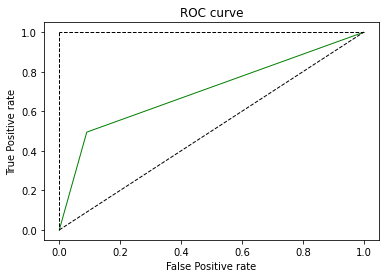

In [14]:
fpr, tpr, _= roc_curve(y_test, y_pred)
auc_random_grid = auc(fpr, tpr)
print('AUC: ',auc_random_grid)
plt.figure()
plt.plot(fpr, tpr, color ='Green', linewidth = 1)
plt.title('ROC curve')
plt.plot([0,1], [0,1], 'k--', lw = 1)
plt.plot([0,0], [1,0], 'k--', lw = 1, color = 'black')
plt.plot([1,0], [1,1], 'k--', lw = 1, color = 'black')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')

In [27]:
randomNumber = np.random.randint(0, dataset.shape[1]+1)

true_value = y.loc[randomNumber]
predicted_value = model.predict(ss.transform([dataset.loc[randomNumber]]))
predicted_value = (predicted_value > 0.5)

print('Actual value: ', true_value[0])
print('Predicted value: ', int(predicted_value[0]))

Actual value:  0
Predicted value:  0


C:\Users\Priyesh Dave\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [28]:
# Saving the first opitimum model
joblib.dump(model, '../Models/model_{}_{}.pkl'.format(round(score * 100 ,2), round(auc_random_grid * 100, 2)))

INFO:tensorflow:Assets written to: ram://d0dd72c9-7779-4e2f-a8d3-0d2f79dbfea0/assets


['../Models/model_87.13_70.22.pkl']

## Using Keras Tuner

In [60]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu',
                               kernel_initializer = 'he_uniform'))
    model.add(Dense(1, activation='linear'))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [61]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Patient Survival Prediction')

INFO:tensorflow:Reloading Oracle from existing project project\Patient Survival Prediction\oracle.json


In [62]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [63]:
tuner.search(X_train_res, y_train_res,
             epochs=100,
             validation_data=(ss.transform(X_test), y_test))

Trial 2 Complete [00h 50m 07s]
val_accuracy: 0.3641909807920456

Best val_accuracy So Far: 0.9052363832791647
Total elapsed time: 01h 25m 21s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
6                 |3                 |num_layers
192               |480               |units_0
416               |384               |units_1
0.001             |0.0001            |learning_rate
352               |32                |units_2
64                |None              |units_3
224               |None              |units_4
288               |None              |units_5
224               |None              |units_6
224               |None              |units_7
384               |None              |units_8
384               |None              |units_9
64                |None              |units_10
416               |None              |units_11

Epoch 1/100
1632/1632 [==============================] - 22s 13ms/step - loss: 4.6036 - accuracy: 0.6993 - val_loss: 3.143

## Using Grid Search

In [59]:
def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=X_train.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
    model.add(Dense(1)) # Note: no activation beyond this point
    
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [60]:
model = KerasClassifier(build_fn=create_model, verbose=0)

C:\Users\PRIYES~1\AppData\Local\Temp/ipykernel_23240/2566461152.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


In [61]:
layers = [[20], [40, 20], [45, 30, 15]]
activations = ['sigmoid', 'relu']
param_grid = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[100])

grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [62]:
grid_result = grid.fit(X_train_res, y_train_res)

In [63]:
grid_result.best_score_, grid_result.best_params_

(0.8609457612037659,
 {'activation': 'relu', 'batch_size': 128, 'epochs': 100, 'layers': [40, 20]})

In [64]:
joblib.dump(grid_result, '../Models/grid.pkl')

INFO:tensorflow:Assets written to: ram://09a78803-1115-4566-baa4-da021ef61d9a/assets


['../Models/grid.pkl']